<a href="https://colab.research.google.com/github/codemist04/Movie-Success-Prediction-and-Sentiment-Study-Project-/blob/main/Movie_Success_Sentiment_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk vaderSentiment wordcloud


In [ ]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [6]:
import pandas as pd

movies = pd.read_csv("/content/movies_metadata.csv", low_memory=False)
reviews = pd.read_csv("/content/rotten_tomatoes_critic_reviews.csv", engine='python')

In [7]:
print(movies.shape)
print(reviews.shape)
movies.head(2)

(45466, 24)
(324565, 8)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [8]:
movies['budget'] = pd.to_numeric(movies['budget'], errors='coerce')
movies['revenue'] = pd.to_numeric(movies['revenue'], errors='coerce')
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
movies['year'] = movies['release_date'].dt.year

# Filter sensible data
movies = movies[(movies['budget'] > 0) & (movies['revenue'] > 0) & (movies['year'] >= 1980)]


In [9]:
movies['roi'] = movies['revenue'] / movies['budget']
movies['success'] = (movies['roi'] >= 1).astype(int)  # 1 = success, 0 = failure

In [10]:
movies[['title','budget','revenue','roi','success']].head()

,title,budget,revenue,roi,success
0,Toy Story,30000000.0,373554033.0,12.451801,1
1,Jumanji,65000000.0,262797249.0,4.043035,1
3,Waiting to Exhale,16000000.0,81452156.0,5.090760,1
5,Heat,60000000.0,187436818.0,3.123947,1
8,Sudden Death,35000000.0,64350171.0,1.838576,1


In [14]:
import re

def normalize_title(t):
    if not isinstance(t,str): return ""
    t = t.lower().strip()
    t = re.sub(r'[^a-z0-9 ]','',t)  # remove punctuation
    return re.sub(r'\s+',' ',t)

def extract_title_from_link(link):
    if not isinstance(link, str): return ""
    # Extract the part after 'm/' and before the next '/' or the end of the string
    match = re.search(r'm/([^/]+)', link)
    if match:
        return normalize_title(match.group(1))
    return ""


movies['title_norm'] = movies['title'].apply(normalize_title)
reviews['title_norm'] = reviews['rotten_tomatoes_link'].apply(extract_title_from_link)

In [17]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

reviews['compound'] = reviews['review_content'].astype(str).apply(lambda t: sia.polarity_scores(t)['compound'])

reviews['sentiment_label'] = reviews['compound'].apply(
    lambda x: 'positive' if x>0.05 else ('negative' if x<-0.05 else 'neutral')
)

In [19]:
reviews[['rotten_tomatoes_link','review_content','compound','sentiment_label']].head(3)

,rotten_tomatoes_link,review_content,compound,sentiment_label
0,m/0814255,A fantasy adventure that fuses Greek mythology...,0.7579,positive
1,m/0814255,"Uma Thurman as Medusa, the gorgon with a coiff...",0.0000,neutral
2,m/0814255,With a top-notch cast and dazzling special eff...,0.4019,positive


In [20]:
movie_sentiment = reviews.groupby('title_norm').agg(
    avg_sentiment=('compound','mean'),
    n_reviews=('compound','count')
).reset_index()


In [21]:
movies = movies.merge(movie_sentiment, on='title_norm', how='left')

In [22]:
from ast import literal_eval

def parse_genres(x):
    try:
        items = literal_eval(x)
        return [d['name'] for d in items] if isinstance(items,list) else []
    except:
        return []

movies['genres_list'] = movies['genres'].apply(parse_genres)
movies['release_month'] = movies['release_date'].dt.month


In [23]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_mat = mlb.fit_transform(movies['genres_list'])
genre_df = pd.DataFrame(genre_mat, columns=mlb.classes_, index=movies.index)

movies = pd.concat([movies, genre_df], axis=1)

In [24]:
features = ['budget','runtime','avg_sentiment','n_reviews','release_month'] + list(mlb.classes_)
movies_model = movies[features + ['success']].fillna(0)

print(movies_model.shape)

X = movies_model[features]
y = movies_model['success']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

(4882, 26)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

logit = LogisticRegression(max_iter=2000).fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=300, random_state=42).fit(X_train, y_train)

pred_log = logit.predict(X_test)
pred_rf = rf.predict(X_test)

print("Logistic Accuracy:", accuracy_score(y_test, pred_log))
print("Random Forest Accuracy:", accuracy_score(y_test, pred_rf))

print("RF AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
print("Confusion Matrix (RF):\n", confusion_matrix(y_test, pred_rf))

Logistic Accuracy: 0.6908904810644831
Random Forest Accuracy: 0.6786079836233367
RF AUC: 0.6204881039980378
Confusion Matrix (RF):
 [[ 80 222]
 [ 92 583]]


In [32]:
from sklearn.metrics import classification_report

# Logistic Regression report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, logit.predict(X_test)))

# Random Forest report
print("Random Forest Classification Report:")
print(classification_report(y_test, rf.predict(X_test)))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       302
           1       0.69      1.00      0.82       675

    accuracy                           0.69       977
   macro avg       0.35      0.50      0.41       977
weighted avg       0.48      0.69      0.56       977

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.26      0.34       302
           1       0.72      0.86      0.79       675

    accuracy                           0.68       977
   macro avg       0.59      0.56      0.56       977
weighted avg       0.64      0.68      0.65       977



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/tmp/ipython-input-921589869.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette="coolwarm")


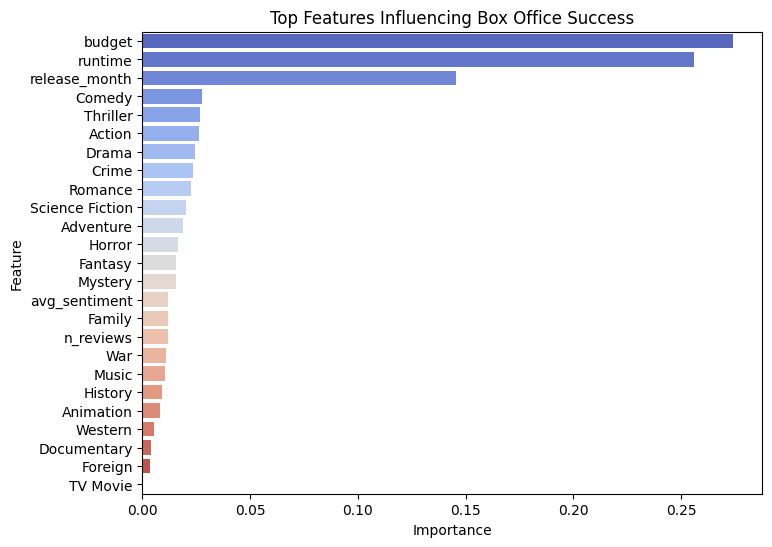

In [41]:
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(8,6))
sns.barplot(x=importances[indices], y=features[indices], palette="coolwarm")
plt.title("Top Features Influencing Box Office Success")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


/tmp/ipython-input-226311337.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genres_list', y='avg_sentiment', data=genre_sent, palette="viridis")


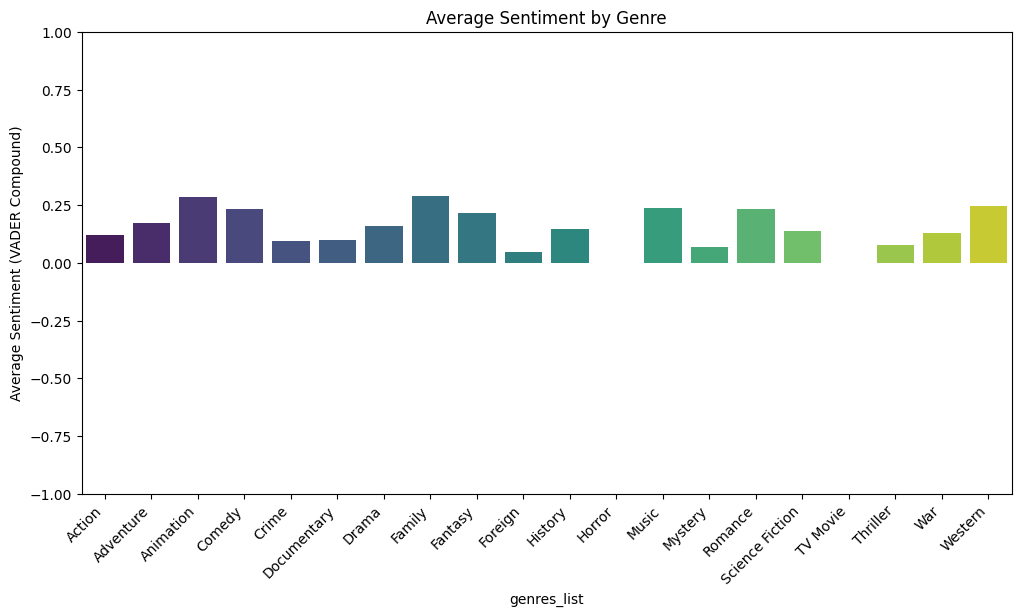

In [27]:
# ✅ Use movie_sentiment (not movies) for genre aggregation
genre_sent = movies.explode('genres_list').groupby('genres_list').agg(
    avg_sentiment=('avg_sentiment','mean'),
    n_movies=('avg_sentiment','count')
).reset_index()

# ✅ Plot
plt.figure(figsize=(12,6))
sns.barplot(x='genres_list', y='avg_sentiment', data=genre_sent, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Sentiment (VADER Compound)")
plt.ylim(-1, 1)   # VADER sentiment range
plt.title("Average Sentiment by Genre")
plt.show()

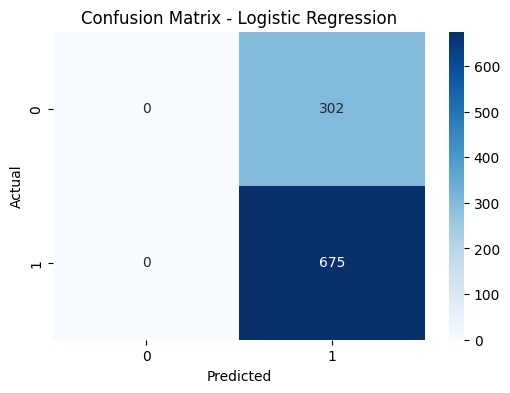

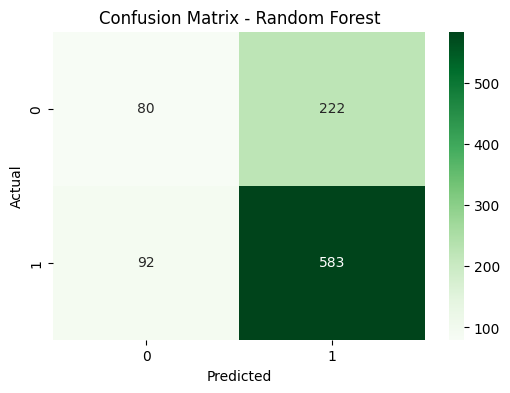

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Logistic Regression CM
cm_log = confusion_matrix(y_test, logit.predict(X_test))
plt.figure(figsize=(6,4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Random Forest CM
cm_rf = confusion_matrix(y_test, rf.predict(X_test))
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/tmp/ipython-input-1490807126.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment_label", data=reviews, palette="Set2", order=["positive","neutral","negative"])


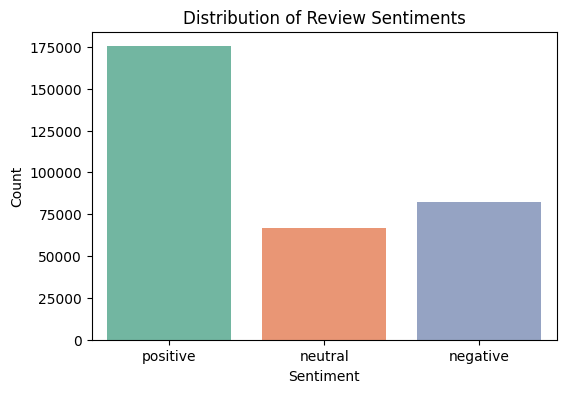

In [36]:
# Assuming you already created 'sentiment_label' with ['positive','negative','neutral']
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment_label", data=reviews, palette="Set2", order=["positive","neutral","negative"])
plt.title("Distribution of Review Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

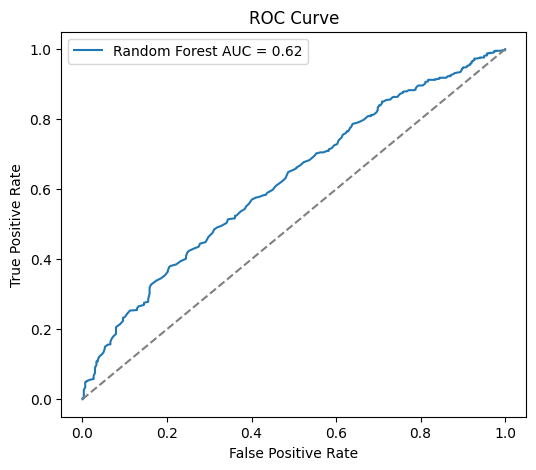

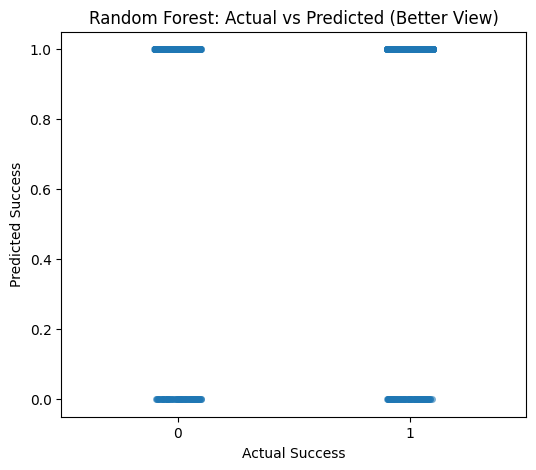

In [52]:
# ROC Curve
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Random Forest AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Stripplot for Actual vs Predicted
plt.figure(figsize=(6,5))
sns.stripplot(x=y_test, y=pred_rf, jitter=True, alpha=0.6)
plt.xlabel("Actual Success")
plt.ylabel("Predicted Success")
plt.title("Random Forest: Actual vs Predicted (Better View)")
plt.show()

In [43]:
import pandas as pd

# Model Metrics Summary
metrics = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [logit.score(X_test, y_test), rf.score(X_test, y_test)],
}
metrics_df = pd.DataFrame(metrics)

# Save to Excel & CSV
with pd.ExcelWriter("project_outputs.xlsx") as writer:
    metrics_df.to_excel(writer, sheet_name="Model Metrics", index=False)
    genre_sentiment.reset_index().to_excel(writer, sheet_name="Genre Sentiment", index=False)
    pd.DataFrame(importances, index=features, columns=["Importance"]).to_excel(writer, sheet_name="Feature Importance")

metrics_df.to_csv("model_metrics.csv", index=False)
genre_sentiment.reset_index().to_csv("genre_sentiment.csv", index=False)

In [44]:
movies[['title','year','budget','revenue','roi','success','avg_sentiment','n_reviews','genres_list']].to_csv("movie_master.csv", index=False)
genre_sent.to_csv("genre_sentiment_summary.csv", index=False)
imp.to_csv("feature_importance.csv")

In [55]:
print("Movies title_norm unique values and counts:")
print(movies['title_norm'].value_counts().head())
print("\nMovie Sentiment title_norm unique values and counts:")
print(movie_sentiment['title_norm'].value_counts().head())

Movies title_norm unique values and counts:
title_norm
beauty and the beast    3
poltergeist             2
neighbors               2
captive                 2
black gold              2
Name: count, dtype: int64

Movie Sentiment title_norm unique values and counts:
title_norm
alien                                     22
1003707 casablanca                        21
1041911 unforgiven                        21
apocalypse now                            21
1010678 invasion of the body snatchers    21
Name: count, dtype: int64


In [53]:
# --- FIX NORMALIZATION + JOIN + GENRE SENTIMENT ---

import re
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# 1) Robust title normalizer (keep spaces; remove punctuation; collapse whitespace)
def normalize_title(s):
    if not isinstance(s, str):
        return ""
    s = s.lower().strip()
    # replace punctuation and separators with a space (NOT empty string)
    s = re.sub(r"[^\w\s]", " ", s)     # drop punctuation
    s = re.sub(r"[_]", " ", s)         # drop underscores as spaces
    s = re.sub(r"\s+", " ", s)         # collapse spaces
    return s.strip()

# Function to extract title from Rotten Tomatoes link
def extract_title_from_link(link):
    if not isinstance(link, str):
        return ""
    # Extract the part after 'm/' and before the next '/' or the end of the string
    match = re.search(r'm/([^/]+)', link)
    if match:
        return normalize_title(match.group(1))
    return ""


# 2) Ensure normalized titles on BOTH dataframes (use the actual movie title column on reviews)
movies['title_norm'] = movies['title'].apply(normalize_title)
# Use the extract_title_from_link function for the reviews dataframe
reviews['title_norm'] = reviews['rotten_tomatoes_link'].apply(extract_title_from_link)


# 3) Ensure YEAR on both sides
# Movies year from release_date
if 'release_date' in movies.columns:
    movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
    movies['year'] = movies['release_date'].dt.year.astype('Int64')

# Reviews year: prefer original_release_date if present, else fall back to review_date
if 'original_release_date' in reviews.columns:
    reviews['year'] = pd.to_datetime(reviews['original_release_date'], errors='coerce').dt.year.astype('Int64')
elif 'review_date' in reviews.columns:
    reviews['year'] = pd.to_datetime(reviews['review_date'], errors='coerce').dt.year.astype('Int64')
else:
    # If neither exists, we’ll proceed without year (less precise joins)
    reviews['year'] = pd.NA

# 4) Compute VADER compound if not already present
if 'compound' not in reviews.columns:
    sia = SentimentIntensityAnalyzer()
    reviews['compound'] = reviews['review_content'].astype(str).apply(lambda t: sia.polarity_scores(t)['compound'])

# 5) Drop rows with missing essentials
reviews = reviews.dropna(subset=['title_norm'])
# Only drop rows with missing year in movies if release_date is used for year
if 'release_date' in movies.columns:
  movies  = movies.dropna(subset=['title_norm', 'year'])
else:
  movies  = movies.dropna(subset=['title_norm'])


# 6) Aggregate review sentiment at (title_norm, year)
# Only group by year if year is available in reviews
if 'year' in reviews.columns and reviews['year'].notna().any():
  movie_sentiment = (
      reviews.dropna(subset=['year'])
             .groupby(['title_norm','year'])
             .agg(avg_sentiment=('compound','mean'),
                  n_reviews=('compound','size'))
             .reset_index()
  )
else:
  movie_sentiment = (
      reviews.groupby(['title_norm'])
             .agg(avg_sentiment=('compound','mean'),
                  n_reviews=('compound','size'))
             .reset_index()
  )

# 7) Build join keys and merge back to movies
# Build join key based on whether year is available in movies
if 'year' in movies.columns and movies['year'].notna().any():
  movies['join_key'] = movies['title_norm'] + '|' + movies['year'].astype(str)
  # Build join key based on whether year is available in movie_sentiment
  if 'year' in movie_sentiment.columns and movie_sentiment['year'].notna().any():
    movie_sentiment['join_key'] = movie_sentiment['title_norm'] + '|' + movie_sentiment['year'].astype(str)
  else:
    # If year is not available in movie_sentiment, cannot create join_key with year
    movies['join_key'] = movies['title_norm']
    movie_sentiment['join_key'] = movie_sentiment['title_norm']
else:
  movies['join_key'] = movies['title_norm']
  movie_sentiment['join_key'] = movie_sentiment['title_norm']

# Drop existing sentiment columns from movies before merging
movies = movies.drop(columns=['avg_sentiment', 'n_reviews'], errors='ignore')

# Merge (left) so movies without reviews keep NaN sentiment
movies = movies.merge(movie_sentiment[['join_key','avg_sentiment','n_reviews']], on='join_key', how='left')

# 8) Parse TMDb genres into a list
def parse_genres(x):
    try:
        lst = literal_eval(x) if isinstance(x, str) else x
        return [d['name'] for d in lst] if isinstance(lst, list) else []
    except Exception:
        return []

if 'genres_list' not in movies.columns:
    movies['genres_list'] = movies['genres'].apply(parse_genres)

# 9) Sanity checks (this replaces the confusing prints you had)
print("\n=== SANITY CHECKS ===")
print("Movies title_norm (top 5):")
print(movies['title_norm'].value_counts().head(), "\n")

print("Movie_sentiment title_norm (top 5):")
print(movie_sentiment['title_norm'].value_counts().head(), "\n")

# Flag suspicious review titles that are digits-only (likely IDs accidentally used as titles earlier)
digits_only = movie_sentiment[movie_sentiment['title_norm'].str.fullmatch(r'\d+')]
print(f"Suspicious rows (digits-only titles) in movie_sentiment: {len(digits_only)}")
if len(digits_only) > 0:
    display(digits_only.head())

# 10) Genre-wise sentiment aggregation and plot
genre_sent = (
    movies.dropna(subset=['avg_sentiment'])
          .explode('genres_list')
          .dropna(subset=['genres_list'])
          .groupby('genres_list')
          .agg(avg_sentiment=('avg_sentiment','mean'),
               n_movies=('avg_sentiment','size'))
          .reset_index()
          .sort_values('avg_sentiment', ascending=False)
)

print("\nGenre sentiment (head):")
print(genre_sent.head())


=== SANITY CHECKS ===
Movies title_norm (top 5):
title_norm
beauty and the beast    3
poltergeist             2
neighbors               2
captive                 2
black gold              2
Name: count, dtype: int64 

Movie_sentiment title_norm (top 5):
title_norm
alien                                     22
1003707 casablanca                        21
1041911 unforgiven                        21
apocalypse now                            21
1010678 invasion of the body snatchers    21
Name: count, dtype: int64 

Suspicious rows (digits-only titles) in movie_sentiment: 145


,title_norm,year,avg_sentiment,n_reviews,join_key
0,0814255,2010,0.281474,140,0814255|2010
1,0814255,2011,0.059300,3,0814255|2011
2,0814255,2012,0.750600,1,0814255|2012
3,0814255,2015,0.726400,1,0814255|2015
4,0814255,2020,0.116050,4,0814255|2020



Genre sentiment (head):
   genres_list  avg_sentiment  n_movies
9      Foreign       0.440400         1
2    Animation       0.290915        21
18     Western       0.280802         3
14     Romance       0.273328       102
7       Family       0.268240        55
